# Test if correlation between $\Delta\Sigma$ and $N_{gal}$ is related to the formation time

## Setup

In [2]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import timeit

## Import Catalogs

In [5]:
ptcl_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/'
deltasigma_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
clusters_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/'

In [6]:
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [7]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [8]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

In [9]:
#matched_halo_df.rename({'T/|U|':'T_U_Ratio'}, inplace=True)

In [10]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## Split sample into quantiles
* Plot difference in DS between all quantiles.
* Find the parameters of interest. 

In [11]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

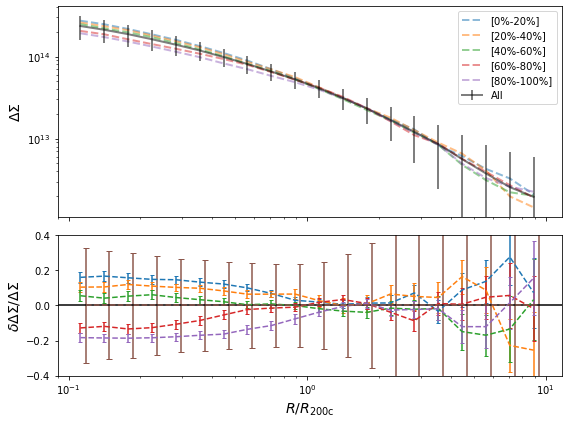

In [12]:
import scipy.stats as stats

##Split the sample by percentile according to split_samp_bins
column_name = 'Xoff'
split_samp_bins_edge = [0,20,40,60,80,100]

x_var = matched_halo_df[column_name]
percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
#print('percentile_var \n', percentile_var)
    
##Create bins with bin edges
x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
bin_num = len(x_var_bin)


f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1.5, 1]}, sharex=True, figsize=(8,6))

mask = (matched_halo_df.M200c >= 1e14) & (matched_halo_df.M200c < 2e14) & (matched_halo_df.scale == 1)
all_df = matched_halo_df[mask]
DS_all = np.vstack(all_df['delta_sigma'])

for i in range(bin_num):
        bin_low = split_samp_bins_edge[i]
        bin_high = split_samp_bins_edge[i+1]
        
        x_var = all_df[column_name]
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
        x_var_bin[i] = x_var[mask]

        cur_df = all_df[mask]
        DS_cur = np.vstack(cur_df['delta_sigma'])
        DS_diff = (np.mean(cur_df['delta_sigma'],axis=0) - np.mean(DS_all,axis=0))/np.mean(DS_all,axis=0)
        DS_diff_err = np.std(DS_cur,axis=0)/np.mean(DS_all,axis=0) * 1/np.sqrt(len(DS_cur))

        a0.plot(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), \
                    label='[{:d}%-{:d}%]'.format(bin_low, bin_high), linewidth=2, alpha=0.5, linestyle='dashed')
    
        a1.errorbar(r_cent_lin_norm, DS_diff, yerr=DS_diff_err, linestyle='dashed', capsize=2)
        
    
a0.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr=np.std(DS_all,axis=0), \
            label='All', linewidth=2, alpha=0.5, linestyle='solid', color='black')
a1.errorbar(1.05*r_cent_lin_norm, np.zeros_like(r_cent_lin_norm), yerr=np.std(DS_all,axis=0)/np.mean(DS_all,axis=0), linestyle='dashed', capsize=3)

    
a0.set_xscale('log'); a0.set_yscale('log')
a0.set_ylabel(r'$\Delta\Sigma$', fontsize=14)
a0.legend()

a1.set_xscale('log')
a1.set_ylabel(r'$\delta\Delta\Sigma/\Delta\Sigma $', fontsize=14)
a1.axhline(0, linestyle='solid', color='black')
a1.set_xlabel(r'$R/R_{\rm 200c}$', fontsize=14)
a1.set_ylim([-0.4,0.4])

f.tight_layout()
#f.savefig(plotdir+'DS_acc_hist_1e14_2e14_{}.pdf'.format(column_name))

plt.show()

## Create a plot containing all 5 parameters
* Xoff
* T/U
* Acc_2Tdyn
* c_vir
* Halfmass_scale

In [13]:
fontsize=20
legendsize=11
fig = plt.figure(tight_layout=True, figsize=(8, 16))
subfigs = fig.subfigures(3, 2, wspace=0.07)

for subfig in subfigs:
    print(0)



0
0
0


<Figure size 576x1152 with 0 Axes>

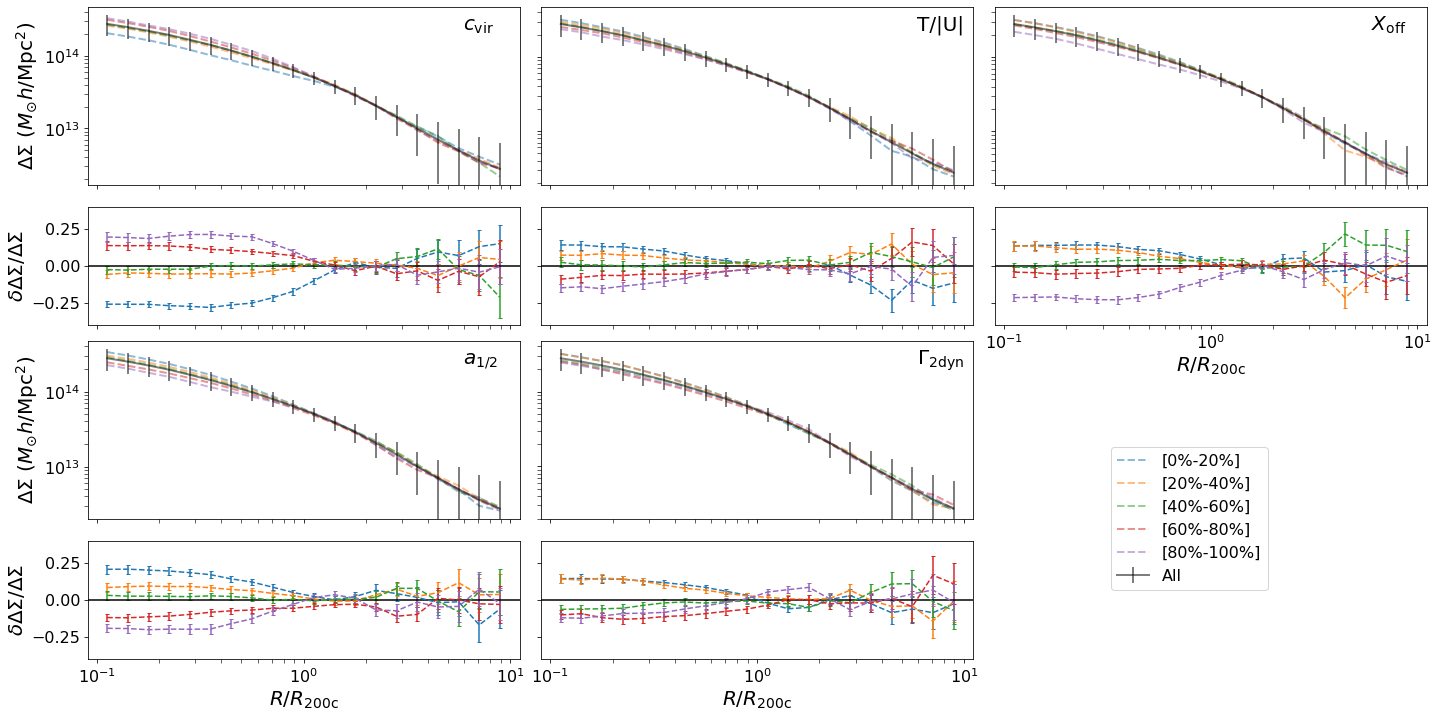

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Plotting 
fontsize=20
legendsize=16

fig = plt.figure(figsize=(24, 12), tight_layout=True)
outer = gridspec.GridSpec(2, 3, wspace=0.05, hspace=0.05)

column_dict = {'c_vir':r'$c_{\rm vir}$','T/|U|':'T/|U|', 'Xoff':r'$X_{\rm off}$', 'Halfmass_Scale':r'$a_{1/2}$', 'Acc_Rate_2*Tdyn':r'$\Gamma_{\rm 2dyn}$'}

i=0
for column_name, column_val in column_dict.items():
    split_samp_bins_edge = [0,20,40,60,80,100]

    x_var = matched_halo_df[column_name]
    percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
    #print('percentile_var \n', percentile_var)

    ##Create bins with bin edges
    x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
    bin_num = len(x_var_bin)
    
    
    ## Inner plots
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], hspace=0.15, height_ratios=[1.5,1])

    axes = np.empty(shape=(2), dtype=object)

    a0 = plt.Subplot(fig, inner[0], sharex=axes[0])
    a1 = plt.Subplot(fig, inner[1], sharex=axes[0])
    #axes[j] = ax
        
    mask = (matched_halo_df.M200c >= 2e14) & (matched_halo_df.M200c < 5e14) & (matched_halo_df.scale == 1)
    all_df = matched_halo_df[mask]
    DS_all = np.vstack(all_df['delta_sigma'])

    for j in range(bin_num):
            bin_low = split_samp_bins_edge[j]
            bin_high = split_samp_bins_edge[j+1]

            x_var = all_df[column_name]
            percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
            mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
            x_var_bin[j] = x_var[mask]

            cur_df = all_df[mask]
            DS_cur = np.vstack(cur_df['delta_sigma'])
            DS_diff = (np.mean(cur_df['delta_sigma'],axis=0) - np.mean(DS_all,axis=0))/np.mean(DS_all,axis=0)
            DS_diff_err = np.std(DS_cur,axis=0)/np.mean(DS_all,axis=0) * 1/np.sqrt(len(DS_cur))

            a0.plot(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), \
                        label='[{:d}%-{:d}%]'.format(bin_low, bin_high), linewidth=2, alpha=0.5, linestyle='dashed')

            a1.errorbar(r_cent_lin_norm, DS_diff, yerr=DS_diff_err, linestyle='dashed', capsize=2)


    a0.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr=np.std(DS_all,axis=0), \
                label='All', linewidth=2, alpha=0.5, linestyle='solid', color='black')
    #a1.errorbar(1.05*r_cent_lin_norm, np.zeros_like(r_cent_lin_norm), yerr=np.std(DS_all,axis=0)/np.mean(DS_all,axis=0), linestyle='None', capsize=3)

    a0.text(0.87, 0.87, column_val,  fontsize =20 , transform=a0.transAxes)
    a0.set_xscale('log'); a0.set_yscale('log')
    
    a1.set_xscale('log')
    a1.axhline(0, linestyle='solid', color='black')
    a1.set_ylim([-0.4,0.4])
        
    if np.isin(i,[2,3,4]):
        a1.set_xlabel(r'$R/R_{\rm 200c}$', fontsize=fontsize)
        
    if np.isin(i, [0,3]):
        a0.set_ylabel(r'$\Delta\Sigma$ ($M_{\odot}h$/Mpc$^2$)', fontsize=fontsize)
        a1.set_ylabel(r'$\delta\Delta\Sigma/\Delta\Sigma $', fontsize=fontsize)
        
    if np.isin(i, 4):
        a0.legend(fontsize=legendsize, loc='center', bbox_to_anchor=(1.5,0) )
        
    if np.isin(i, 5):
        a0.set_visible(False)
        a1.set_visible(False)
        
    ##Converting between labels
    a0.xaxis.set_tick_params(labelbottom=False)
    
    a0.tick_params(which='both', length=4, labelsize=16)
    a1.tick_params(which='both', length=4, labelsize=16)
    
    if not np.isin(i, [0,3]) :
        a0.yaxis.set_tick_params(labelleft=False)
        a0.yaxis.set_tick_params(labelleft=False)
        a1.yaxis.set_tick_params(labelleft=False)
        a1.yaxis.set_tick_params(labelleft=False)
        
    if np.isin(i, [0,1]) :
        a1.xaxis.set_tick_params(labelbottom=False)
        
      
    fig.add_subplot(a0)
    fig.add_subplot(a1)
    
    i+=1
    
#a1.legend(loc='center', bbox_to_anchor=(2.5,0.5), fontsize=legendsize)

fig.savefig(plotdir+'DS_acc_history_all_2e14_5e14_z0p00.pdf', bbox_inches='tight', pad_inches=0)
fig.show()

(-0.4, 0.4)

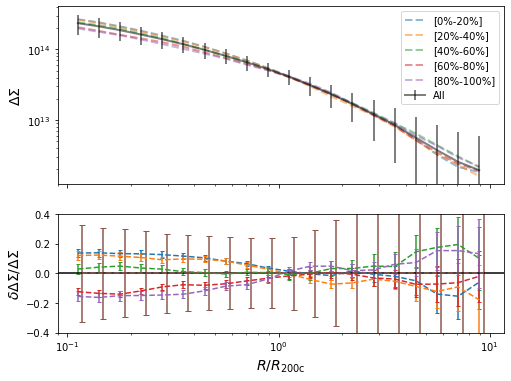

In [15]:



f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1.5, 1]}, sharex=True, figsize=(8,6))

mask = (matched_halo_df.M200c >= 1e14) & (matched_halo_df.M200c < 2e14) & (matched_halo_df.scale == 1)
all_df = matched_halo_df[mask]
DS_all = np.vstack(all_df['delta_sigma'])

for i in range(bin_num):
        bin_low = split_samp_bins_edge[i]
        bin_high = split_samp_bins_edge[i+1]
        
        x_var = all_df[column_name]
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
        x_var_bin[i] = x_var[mask]

        cur_df = all_df[mask]
        DS_cur = np.vstack(cur_df['delta_sigma'])
        DS_diff = (np.mean(cur_df['delta_sigma'],axis=0) - np.mean(DS_all,axis=0))/np.mean(DS_all,axis=0)
        DS_diff_err = np.std(DS_cur,axis=0)/np.mean(DS_all,axis=0) * 1/np.sqrt(len(DS_cur))

        a0.plot(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), \
                    label='[{:d}%-{:d}%]'.format(bin_low, bin_high), linewidth=2, alpha=0.5, linestyle='dashed')
    
        a1.errorbar(r_cent_lin_norm, DS_diff, yerr=DS_diff_err, linestyle='dashed', capsize=2)
        
    
a0.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr=np.std(DS_all,axis=0), \
            label='All', linewidth=2, alpha=0.5, linestyle='solid', color='black')
a1.errorbar(1.05*r_cent_lin_norm, np.zeros_like(r_cent_lin_norm), yerr=np.std(DS_all,axis=0)/np.mean(DS_all,axis=0), linestyle='dashed', capsize=3)

    
a0.set_xscale('log'); a0.set_yscale('log')
a0.set_ylabel(r'$\Delta\Sigma$', fontsize=14)
a0.legend()

a1.set_xscale('log')
a1.set_ylabel(r'$\delta\Delta\Sigma/\Delta\Sigma $', fontsize=14)
a1.axhline(0, linestyle='solid', color='black')
a1.set_xlabel(r'$R/R_{\rm 200c}$', fontsize=14)
a1.set_ylim([-0.4,0.4])

In [16]:
from scipy import stats
'''
split_samp_bins: Defines bin edges in terms of percentile of the samples split. Closed in low end and open in high end, e.g. [0,0.5,1] creates two bins [0,0.5) and [0.5,1).
Default is two bins high and low split by the median. 
'''

def plot_corr_split_samp(column_name, nBoot=20, split_samp_bins_edge = [0,0.5,1]):

    ##Split the sample by percentile according to split_samp_bins

    #print('percentile_var \n', percentile_var)

    ##Create bins with bin edges
    x_var_bin = [[] for i in range(len(split_samp_bins_edge)-1)]
    bin_num = len(x_var_bin)
    
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(8,8))

    mask = (matched_halo_df.mvir >= 1e14) & (matched_halo_df.mvir < 2e14)
    all_df = matched_halo_df[mask]
    DS_all = np.vstack(all_df['delta_sigma'])
    for i in range(bin_num):
        bin_low = split_samp_bins_edge[i]
        bin_high = split_samp_bins_edge[i+1]
        
        x_var = all_df[column_name]
        percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
        mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
        x_var_bin[i] = x_var[mask]

        cur_df = all_df[mask]
        DS_cur = np.vstack(cur_df['delta_sigma'])
        DS_diff = (np.mean(cur_df['delta_sigma'],axis=0) - np.mean(DS_all,axis=0))/np.mean(DS_all,axis=0)
        DS_diff_err = np.std(DS_cur,axis=0)/np.mean(DS_all,axis=0) * 1/np.sqrt(len(DS_cur))

        a0.plot(r_cent_lin_norm, np.mean(cur_df['delta_sigma'],axis=0), \
                        label='[{:d}%-{:d}%]'.format(bin_low, bin_high), linewidth=2, alpha=0.5, linestyle='dashed')

        a1.errorbar(r_cent_lin_norm, DS_diff, yerr=DS_diff_err, linestyle='dashed')

    a0.errorbar(r_cent_lin_norm, np.mean(DS_all,axis=0), yerr=np.std(DS_all,axis=0), \
                label='All', linewidth=2, alpha=0.5, linestyle='solid', color='black')

    a0.set_xscale('log'); a0.set_yscale('log')
    a0.set_ylabel(r'$\Delta\Sigma$', fontsize=14)
    a0.legend()

    a1.set_xscale('log')
    a1.axhline(0, linestyle='solid', color='black')
    a1.set_xlabel(r'$R/R_{\rm vir}$', fontsize=14)
    a1.set_ylabel(r'$\delta\Delta\Sigma(R)$', fontsize=14)

    f.tight_layout()

    plt.show()

    return

#plot_corr_split_samp('Ngal', nBoot=20, split_samp_bins = [])
column_names = 'Ngal'
plt.hist(matched_halo_df['Ngal'], alpha=0.3)
plt.axvline(np.mean(matched_halo_df['Ngal']))

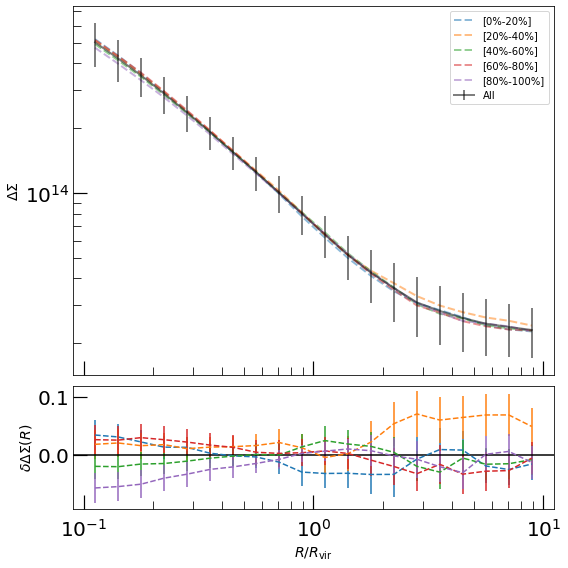

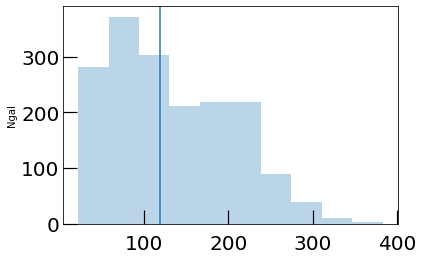

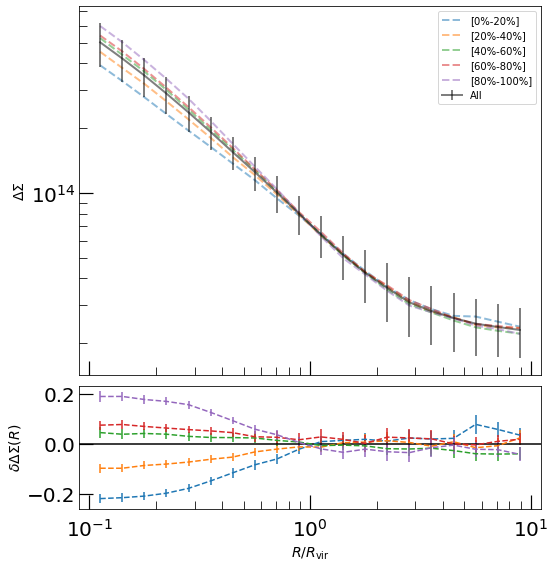

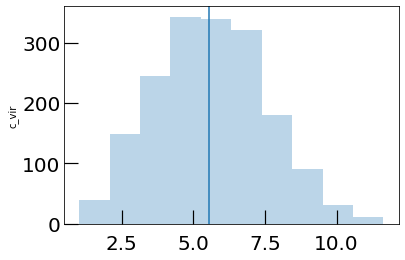

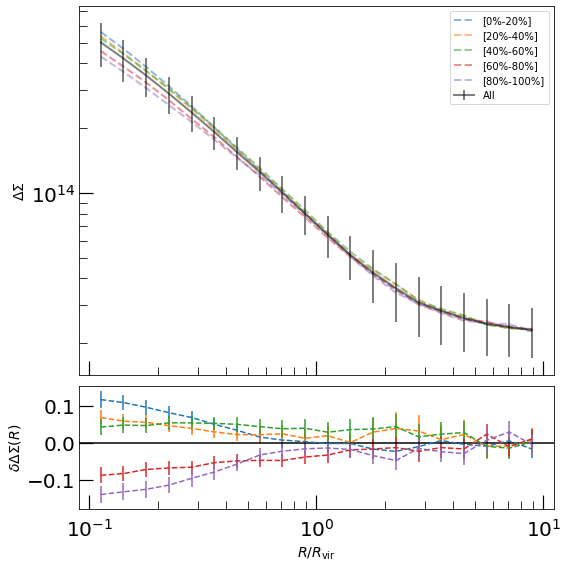

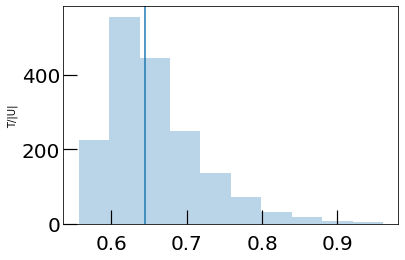

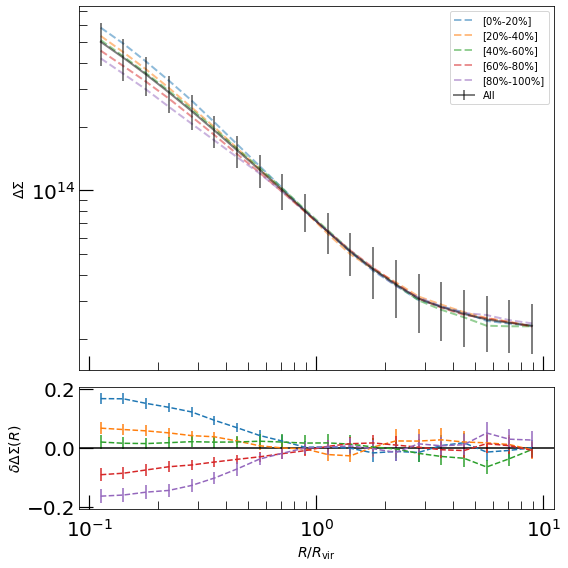

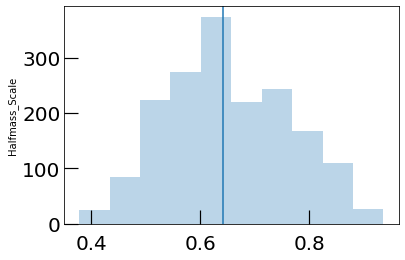

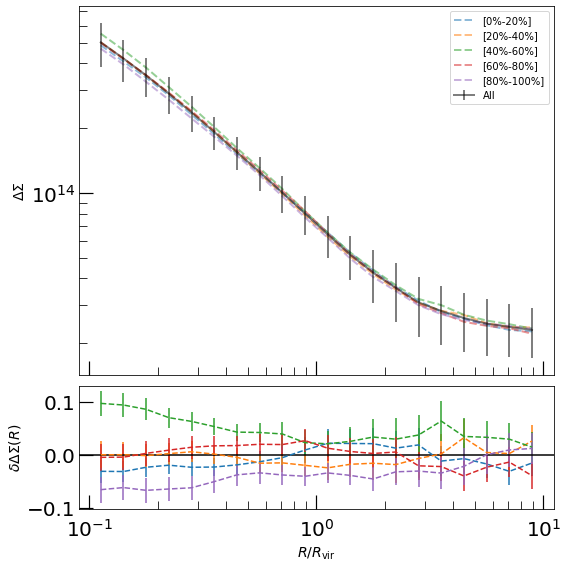

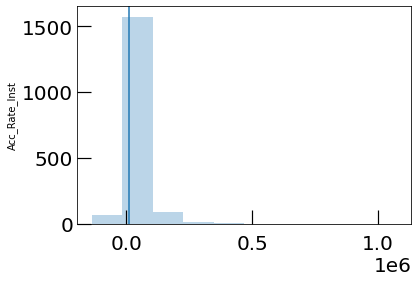

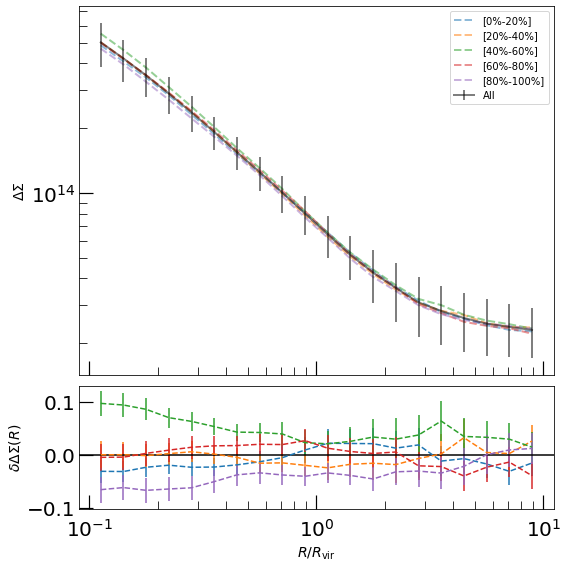

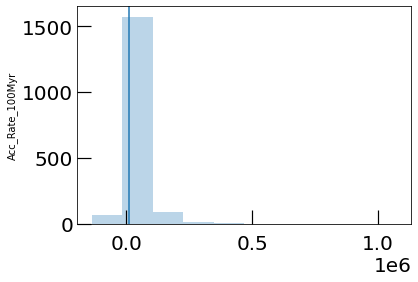

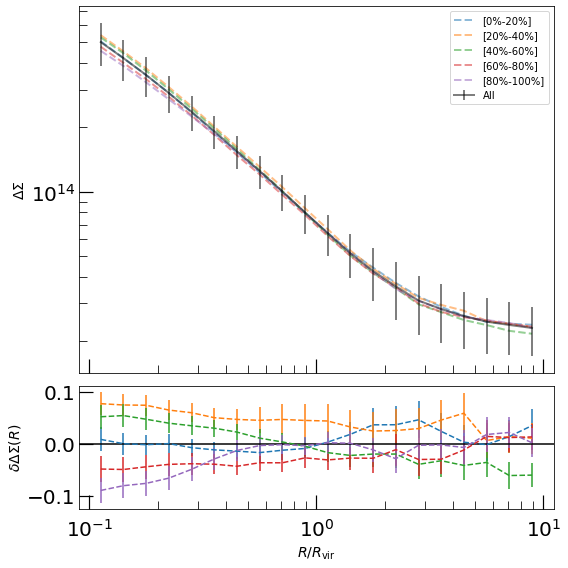

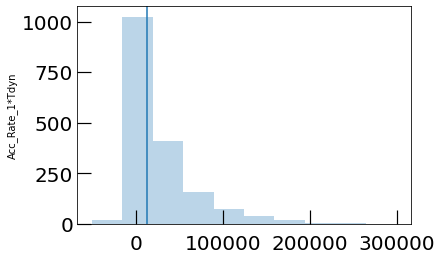

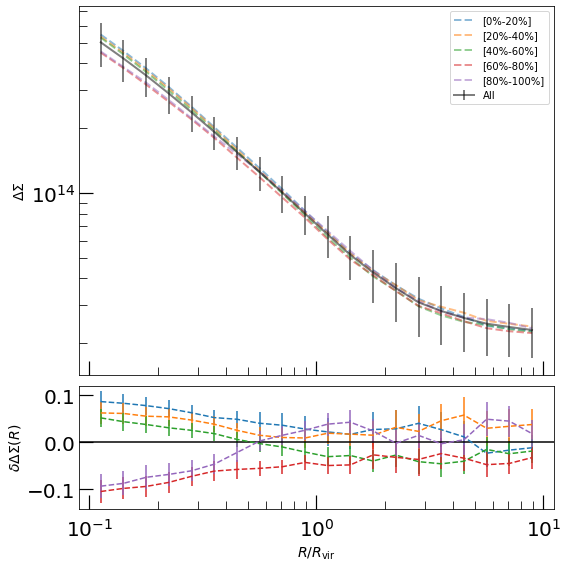

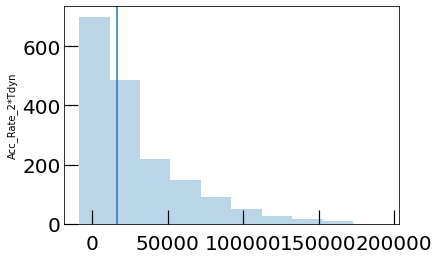

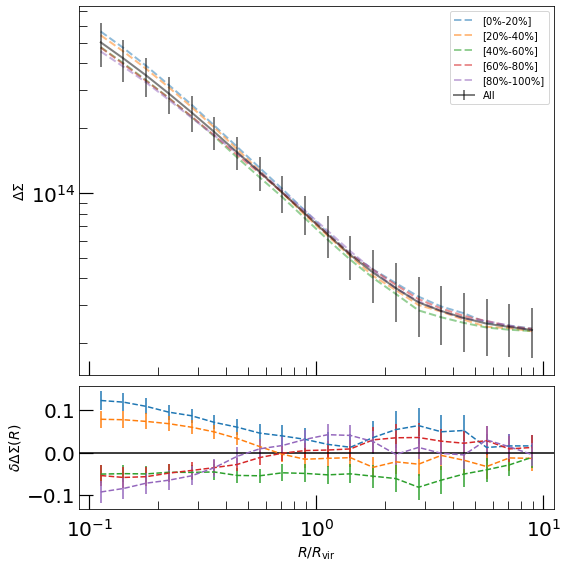

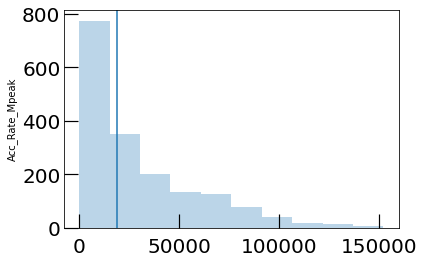

In [66]:
#plot_corr_split_samp('Ngal', nBoot=20, split_samp_bins = [])
column_names = ['Ngal', 'c_vir','T/|U|','Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak']

for column_name in column_names:
    plot_corr_split_samp(column_name, nBoot=10, split_samp_bins_edge = [0,20,40,60,80,100])
    plt.hist(matched_halo_df[column_name], alpha=0.3)
    plt.axvline(np.median(matched_halo_df[column_name]))
    plt.ylabel(column_name)
    plt.show()

## Correlation upon localizing a MAH parameter

In [39]:
import sys
sys.path.append('/global/u1/z/zzhang13')
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *


## Create function to calculate the scatter binned by radius
'''
Calculates the Covariance of the scatter of <f(X,R)> = Y in different radial bins using KLLR. 
---------------------

X: Independent variable array (e.g. Mass)
Y: profile array. Rows are the different halos and columns X-dependent profiles in each radial bins. 
Z: The global quantities (e.g Richness). Len should be number of halos. 
kernel_type: kernel for LLR
kernel_width: width of Gaussian or tophat.
'''
def calc_scatter_cov_radii(x, Y, Z, xrange=None, nbins = 10, kernel_type='gaussian', kernel_width=0.1, nBootstrap=1):     
    output_Data = {}
    
    if len(x.shape) == 1: x = x[:, None] #Make sure X is atleast 2D
    xline = setup_bins(xrange, nbins, x[:, 0])
    cov_bins = np.shape(Y)[1] ## Radial bins
    correlation = np.zeros((nBootstrap, cov_bins))
    covariance = np.zeros((nBootstrap, cov_bins))
    
    #Within each bin apply the KLLR algorithm
    lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
    dz = lm.residuals(x, Z, bins=nbins, nBootstrap = 1,
                fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)
    
    #How to bootstrap resample 
    for i in range(nBootstrap):
        #First "bootstrap" is always using unsampled data
        if i == 0:
            rand_ind = np.ones(Z.size).astype(bool)
        else:
            rand_ind = np.random.randint(0, Z.size, Z.size)

        x_rand = x[rand_ind]
        Z_rand = Z[rand_ind]
        Y_rand = Y[rand_ind, :]
        
        #Bootstrap done outside the function, not inside the function. 
        dz = lm.residuals(x_rand, Z_rand, bins=nbins, nBootstrap = 1,
                fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)
        
        for j in range(cov_bins):
            #Find the data in the i/jth bin
            y_j = Y_rand[:, j]

            #residuals give the scatter normalized by the mean scatter in that bin
            dy_j = lm.residuals(x_rand, y_j, bins=nbins, nBootstrap = 1,
                      fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)

            cov = np.cov(dz, dy_j) #Should consider the weights of the covariance matrix?
            covariance[i,j] = cov[1, 0]
            correlation[i,j] = cov[1, 0]/np.sqrt(cov[0,0] * cov[1,1])            
    
    output_Data['covariance'] = covariance
    output_Data['correlation'] = correlation
    return xline, output_Data

## Localizing parameter

* Construct a Gaussian centered around the median with standard deviation 1/4 of the standard deviation of the parameter. 
* Resample and check that the correlation is 0 given errors after this correction. 

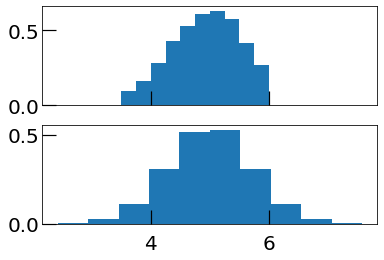

In [40]:
import matplotlib.pyplot as plt


lower, upper = 3.5, 6
mu, sigma = 5, 0.7
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
N = stats.norm(loc=mu, scale=sigma)

fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(X.rvs(10000), density=True)
ax[1].hist(N.rvs(10000), density=True)
plt.show()

In [41]:
##mass bins 
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

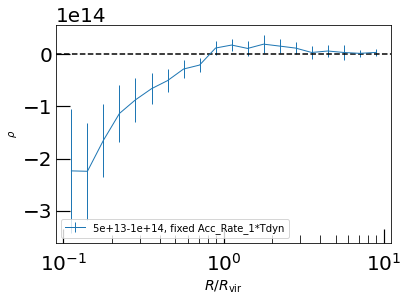

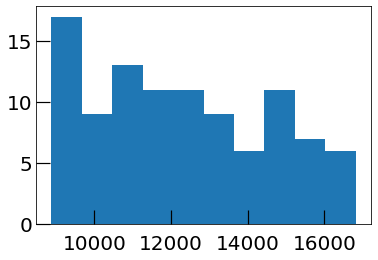

In [51]:
column_name = 'Acc_Rate_1*Tdyn'

##Split the sample by percentile according to split_samp_bins
x_var = matched_halo_df[column_name]
x_median = np.median(x_var)
x_std = np.std(x_var)
x_high = np.max(x_var); x_low = np.min(x_var)
    
kernel_width = x_std/10
mask = (matched_halo_df.mvir >= 1e14) & (matched_halo_df.mvir < 2e14)
mask &= (x_var > (x_median - kernel_width)) & (x_var < (x_median + kernel_width))
cur_df = matched_halo_df[mask]
    
xline, output_all = calc_scatter_cov_radii(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.array(cur_df['Ngal'],dtype=float), nBootstrap=20)
cov_ds_ngal = output_all['covariance']
corr_ds_ngal = output_all['correlation']
cov_mean = np.mean(cov_ds_ngal, axis=0)
cov_err = np.std(cov_ds_ngal, axis=0)
corr_mean = np.mean(corr_ds_ngal, axis=0)
corr_err = np.std(corr_ds_ngal, axis=0)
                                        
plt.errorbar(r_cent_lin_norm, cov_mean, yerr= cov_err, label='{:.2g}-{:.2g}, fixed {}'.format(mass_min, mass_max, column_name), linewidth=1, alpha=1)
plt.axhline(0,linestyle='dashed', color='black')
plt.xscale('log')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
plt.legend()
plt.show()    

plt.hist(cur_df[column_name])
plt.show()

In [18]:
column_name = 'Ngal'

##Split the sample by percentile according to split_samp_bins
x_var = matched_halo_df[column_name]
x_median = np.median(x_var)
x_std = np.std(x_var)
x_high = np.max(x_var); x_low = np.min(x_var)
    
kernel_width = x_std/3
mask = (x_var > (x_median - kernel_width)) & (x_var < (x_median + kernel_width))
    
## Plotting all mass bins
for cur_bin in iter(mass_bins):
    #Filter current mass bin
    mass_min = cur_bin[0]; mass_max = cur_bin[1]
    mask_mass = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
        
    ##Split the sample by percentile according to split_samp_bins
    x_var = matched_halo_df[column_name]
    x_median = np.median(x_var)
    x_std = np.std(x_var)
    x_high = np.max(x_var); x_low = np.min(x_var)

    kernel_width = x_std/3
    mask_column = (x_var > (x_median - kernel_width)) & (x_var < (x_median + kernel_width))

    mask = mask_mass & mask_column
    cur_df = matched_halo_df[mask]
        
    xline, output_all = calc_scatter_cov_radii(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.array(cur_df['Ngal'],dtype=float), nBootstrap=20)
    cov_ds_ngal = output_all['covariance']
    corr_ds_ngal = output_all['correlation']
    cov_mean = np.mean(cov_ds_ngal, axis=0)
    cov_err = np.std(cov_ds_ngal, axis=0)
    corr_mean = np.mean(corr_ds_ngal, axis=0)
    corr_err = np.std(corr_ds_ngal, axis=0)
                                        
    plt.errorbar(r_cent_lin_norm, corr_mean, yerr= corr_err, label='{:.2g}-{:.2g}, fixed {}'.format(mass_min, mass_max, column_name), linewidth=1, alpha=1)
    plt.axhline(0,linestyle='dashed', color='black')
    plt.xscale('log')
    plt.ylabel(r'$\rho$')
    plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
    plt.legend()
    plt.show()
    

The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var_true = var_obs - y_err^2, is negative.
The uncertainty, y_err, is larger than the instrinsic scatter. The corrected variance, var

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [ ]:
import scipy.stats as stats
'''
split_samp_bins: Defines bin edges in terms of percentile of the samples split. Closed in low end and open in high end, e.g. [0,0.5,1] creates two bins [0,0.5) and [0.5,1).
Default is two bins high and low split by the median. 
'''

def DS_resample_bycolumn(column_name):
    global matched_halo_df
    
    ##Split the sample by percentile according to split_samp_bins
    x_var = matched_halo_df[column_name]
    x_median = np.median(x_var)
    x_std = np.std(x_var)
    x_high = np.max(x_var); x_low = np.min(x_var)
    
    kernel_width = x_std/3
    mask = (x_var > (x_median - kernel_width)) & (x_var < (x_median + kernel_width))
    
    ## Plotting all mass bins
    for cur_bin in iter(mass_bins):
        #Filter current mass bin
        mass_min = cur_bin[0]; mass_max = cur_bin[1]
        mask_mass = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max)
        
        ##Split the sample by percentile according to split_samp_bins
        x_var = matched_halo_df[column_name]
        x_median = np.median(x_var)
        x_std = np.std(x_var)
        x_high = np.max(x_var); x_low = np.min(x_var)

        kernel_width = x_std/3
        mask_column = (x_var > (x_median - kernel_width)) & (x_var < (x_median + kernel_width))

        mask = mask_mass & mask_column
        cur_df = matched_halo_df[mask]
        
        xline, output_all = calc_scatter_cov_radii(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.vstack(cur_df['delta_sigma']), \
                                       np.array(cur_df['Ngal'],dtype=float), nBootstrap=20)
        cov_ds_ngal = output_all['covariance']
        corr_ds_ngal = output_all['correlation']
        cov_mean = np.mean(cov_ds_ngal, axis=0)
        cov_err = np.std(cov_ds_ngal, axis=0)
        corr_mean = np.mean(corr_ds_ngal, axis=0)
        corr_err = np.std(corr_ds_ngal, axis=0)
                                        
        plt.errorbar(r_cent_lin_norm, corr_mean, yerr= corr_err, label='{:.2g}-{:.2g}, fixed {}',format(mass_min, mass_max, column_name), linewidth=1, alpha=1)
        plt.axhline(0,linestyle='dashed', color='black')
        plt.xscale('log')
        plt.ylabel(r'$\rho$')
        plt.xlabel(r'$R/R_{\rm vir}$', fontsize=14)
        plt.legend()
        plt.show()
        